# Sparse Sheaf Signal Processing

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from vdm import VDM
import cvxpy as cp
from sklearn.linear_model import OrthogonalMatchingPursuit
from wavelet import Wavelet
from builder import CochainSample # builder.py file provided by project supervisor
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from utils import fibonacci_sphere, geodetic_to_ecef, project_to_tangent
import warnings
warnings.filterwarnings("ignore")

SEED = 6111983
np.random.seed(SEED)

# Synthetic Datasets

## Random Point Cloud in a Cube

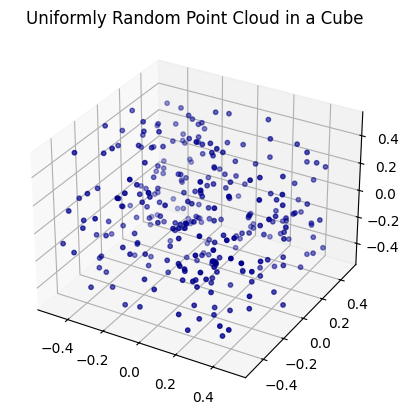

In [2]:
# Generate a cube in R^3 with uniformly random points
N = 300 # number of points in the cloud
np.random.seed(6111983)
cube_point_cloud = np.random.uniform(-0.5,0.5,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube_point_cloud[:,0], cube_point_cloud[:,1], cube_point_cloud[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

#### VDM

In [3]:
x = cube_point_cloud  # data
eps = 0.1 # epsilon for the graph
eps_pca = 0.05 # epsilon for the local PCA
k = 30 # number of neighbors in knn
gamma = 0.95 # information variability threshold in dimension estimation with singular values

# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma)

# Create the graph
G = vdm.make_graph(method='radius') # method must be 'radius' or 'knn', the default is 'radius'
# 'radius': radius nearest neighbors adds an edge (i,j) if ||x[i]-x[j]|| < sqrt(eps)   -> hyperparameter eps
# 'knn': adds edges between a node and its k nearest neighbors       -> hyperparameter k

# Orthonormal bases
O = vdm.make_orthonormal_bases()

# Print manifold dimension
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")

Estimated dimension of the manifold: 2


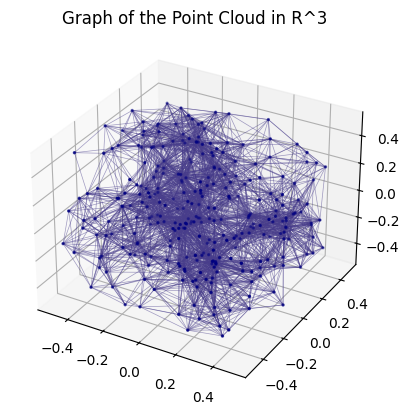

In [4]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

#### Build the Laplacians

##### Connection Laplacian

In [5]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_conn = vdm.connection_laplacian() # approximation of the connection laplacian

##### Trivial Laplacian

In [6]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
D = vdm.get_kron_degree_matrix()
D_diag= np.diag(D)
D_diag_sqrt = np.sqrt(D_diag)
L_trivial = np.kron(np.diag(d) - W, np.eye(2)) # Kronecker Graph Laplacian
L_trivial_norm = np.diag(1./D_diag_sqrt) @ L_trivial @ np.diag(D_diag_sqrt) # Normalized Kronecker Graph Laplacian

##### Sheaf Laplacian

In [7]:
# Build sheaf Laplacian
# Define edge orientation as follows: edge (i,j) has tail i and head j with i<j
def coboundary_map(G,O,d):
    '''
    Function that builds the coboundary map of a sheaf given a graph G and O dictionary of alignment matrices Oij
    Assumption: all restriction maps (alignment matrices) have the same dimension dxd
    Inputs:
    G = graph
    O = dictionary of alignment matrices/ restriction maps (O[i][j] is the restriction map from node i to edge (i,j))
    d = dimension of the matrices
    Returns:
    delta = coboundary map
    '''
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    delta = np.zeros((num_edges*d,num_nodes*d))
    for edge_idx, edge in enumerate(G.edges()):
        if edge[0]<edge[1]:
            i = int(edge[0])
            j = int(edge[1])
        else:
            i = int(edge[1])
            j = int(edge[0])
        delta[edge_idx*d:(edge_idx+1)*d, i*d:(i+1)*d] = O[i][j] * G.get_edge_data(i,j)['weight']  # multiply by edge weight
        delta[edge_idx*d:(edge_idx+1)*d, j*d:(j+1)*d] = - O[j][i] * G.get_edge_data(j,i)['weight']
    return delta

def sheaf_laplacian(G,O,d):
    delta = coboundary_map(G,O,d)
    L = delta.T @ delta
    return L

In [8]:
# Build sheaf laplacian
alignment_matrices = vdm.make_alignment_matrices()
L_sheaf = sheaf_laplacian(G,alignment_matrices,2)

### Generate Signals

#### Steps for Building the signals

1. We already have the geometry: $x \in \mathbb{R}^{N \times 3}$ and $O[i] \in \mathbb{R}^{3 \times 2}$

2. Generating a Kraichnan Field, computing:

$$
\mathbf{U}(x) = \bar{U} \mathbf{e}_1 - \sqrt{\frac{\sigma^2}{n}} \sum_{i=1}^n \mathbf{p}(\mathbf{k_i}) [Z_{1,i} \cos(\langle \mathbf{k_i}, \mathbf{x} \rangle) + \sin(\langle \mathbf{k_i}, \mathbf{x} \rangle)]
$$

with the projector

$$
\mathbf{p}(\mathbf{k_i}) = \mathbf{e_1} - \frac{\mathbf{k_i} k_1}{\mathbf{k}^2}
$$

and the incompressibility property $ \nabla \cdot \mathbf{U}=0$.

3. Sampling the field on the points, finding $u_i = U(x_i) \in \mathbb{R}^3$. The result is a matrix U in $R^{3 \times N}$ where $N$ is the number of nodes.

4. Projecting the points onto the tangent spaces: $O_i^T u_i \in \mathbb{R}^2$ for every point. Together, they form a matrix in $\mathbb{R}^{2N}$.

5. We repeat points 2-4 $M$ times, ending up with a matrix $X \in \mathbb{R}^{2N \times M}$.

6. Computing the covariance matrix $\Sigma \in \mathbb{R}^{2N \times 2N}$

##### Kraichnan

In [9]:
# Kraichnan Field Generation

# Parameters
n = 100 # number of waves
sigma = 1 # strength
U_bar = 0 # mean flow
SEED = 6111983 # random seed

def kraichnan_r3(x, k, Z, n=100, sigma=1, U_bar=0):
    '''
    Function that computes the a vector field for R^3
    x = points in R^3 (N x 3)
    k = precomputed normal random vectors (n x 3)
    Z = precomputed normal random numbers (n x 1)
    n = number of waves
    sigma = strength
    U_bar = mean flow
    seed = random seed
    '''
    # Define the field
    e1 = np.array([1, 0, 0])
    mult_factor = np.sqrt(sigma**2 / n)
    U = np.tile(U_bar*e1, (len(x),1)).astype(np.float64)
    for i in range(n):
        projector = e1 - (k[i]*k[i][0]) / np.dot(k[i], k[i])
        phase = x @ k[i] # N
        wave = Z[i] * np.cos(phase) + np.sin(phase) # N
        U -= mult_factor * wave[:,None] * projector[None,:]  # broadcast
    return U

# Monte Carlo samples
M = 100
X = np.zeros((2*N, M))

# Random seed
rng = np.random.default_rng(SEED)

for m in range(M):
    # Compute normal random vectors k_i and random scalars z_i
    k = rng.normal(size=(n,3))
    Z = rng.normal(size=n)
    U = kraichnan_r3(x,k,Z) # Field sample
    for i in range(N):
        X[2*i : 2*i+2, m] = O[i].T @ U[i] # Projection onto the orthonormal basis

##### Covariance

In [10]:
# Function that computes the empirical covariance
def empirical_covariance(X):
    X_mean = np.mean(X, axis=1, keepdims=True) # 2N x 1
    X_centered = X - X_mean # 2N x M
    cov = (X_centered @ X_centered.T) / (X.shape[1] - 1)
    return cov

# Compute the empirical covariance
cov = empirical_covariance(X)

#### Generate Signals using CochainSample

In [11]:
# Create a CochainSample object
sample = CochainSample(X=X,
                       covariance=cov,
                       X_GT=X,
                       points=x,
                       local_bases=O,
                       V=x.shape[0]
                       )
# Saplming signals
sampled = sample.random_tangent_bundle_signals(Sigma=None,len_scale=10, M=500, seed=42)
# Get the results
signals = sampled.X
signal_cov = sampled.covariance
signal_GT = sampled.X_GT

### Dictionaries

In [12]:
# Create the wavelet objects
wav_conn = Wavelet(-L_conn)
wav_trivial = Wavelet(L_trivial)
wav_trivial_norm = Wavelet(L_trivial_norm)
wav_sheaf = Wavelet(L_sheaf)

In [13]:
# Define the scales
num_scales = 7
scales = [2**(j-4) for j in range(num_scales)]
shifts = np.arange(L_trivial.shape[0])
# Build the dictionaries
dict_conn = wav_conn.make_dictionary(scales, shifts)
dict_trivial = wav_trivial.make_dictionary(scales, shifts)
dict_trivial_norm = wav_trivial_norm.make_dictionary(scales, shifts)
dict_sheaf = wav_sheaf.make_dictionary(scales, shifts)

### Sparse Signal Processing

We want to find sparse representations of the signals using the laplacian dictionaries.

To evaluate the quality of the signal representation, two measures are taken into consideration:
- Number of non-zero coefficients (or above a tolerance)
- Approximation error

In [16]:
# Find the sparse signal representations
sparse_signals_conn = []
sparse_signals_trivial = []
sparse_signals_trivial_norm = []
sparse_signals_sheaf = []

for k in  tqdm(range(50)):  # tqdm(range(signals.shape[1])):
    sparse_signals_conn.append(wav_conn.sparse_signal(signals[:,k], dict_conn))
    sparse_signals_trivial.append(wav_trivial.sparse_signal(signals[:,k], dict_trivial))
    sparse_signals_trivial_norm.append(wav_trivial_norm.sparse_signal(signals[:,k], dict_trivial_norm))
    sparse_signals_sheaf.append(wav_sheaf.sparse_signal(signals[:,k], dict_sheaf))

100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


In [48]:
# Compute the sparsity of the signal representations
sparsity_conn = []
sparsity_trivial = []
sparsity_trivial_norm = []
sparsity_sheaf = []

for k in range(50):
    sparsity_conn.append(np.sum(np.abs(sparse_signals_conn[k])>0) / dict_conn.shape[1] * 100)
    sparsity_trivial.append(np.sum(np.abs(sparse_signals_trivial[k])>0) / dict_trivial.shape[1] * 100)
    sparsity_trivial_norm.append(np.sum(np.abs(sparse_signals_trivial_norm[k])>0) / dict_trivial_norm.shape[1] * 100)
    sparsity_sheaf.append(np.sum(np.abs(sparse_signals_sheaf[k])>0) / dict_sheaf.shape[1] * 100)

In [40]:
# Compute the NMSE of the sparse signal represntations
nmse_conn = []
nmse_trivial = []
nmse_trivial_norm = []
nmse_sheaf = []


def NMSE(x, x_hat):
    return np.linalg.norm(x - x_hat)**2 / np.linalg.norm(x)**2

for k in range(50):
    nmse_conn.append(NMSE(signal_GT[:,k], dict_conn @sparse_signals_conn[k]))
    nmse_trivial.append(NMSE(signal_GT[:,k], dict_trivial @sparse_signals_trivial[k]))
    nmse_trivial_norm.append(NMSE(signal_GT[:,k], dict_trivial_norm @sparse_signals_trivial_norm[k]))
    nmse_sheaf.append(NMSE(signal_GT[:,k], dict_sheaf @sparse_signals_sheaf[k]))

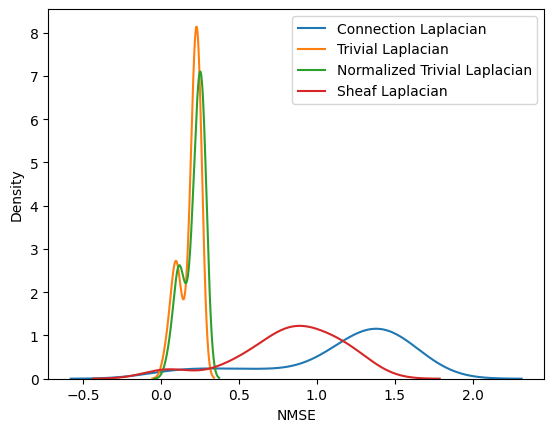

In [58]:
sns.kdeplot(nmse_conn, label='Connection Laplacian')
sns.kdeplot(nmse_trivial, label='Trivial Laplacian')
sns.kdeplot(nmse_trivial_norm, label='Normalized Trivial Laplacian')
sns.kdeplot(nmse_sheaf, label='Sheaf Laplacian')
plt.xlabel('NMSE')
plt.ylabel('Density')
plt.legend()
plt.show()

In [60]:
# Print results
print(f"Number of coefficients (connection laplacian): {np.sum(np.abs(sparse_signals_conn[0])>0)}")
print(f"Number of coefficients (trivial laplacian): {np.sum(np.abs(sparse_signals_trivial[0])>0)}")
print(f"Number of coefficients (normalized trivial laplacian): {np.sum(np.abs(sparse_signals_trivial_norm[0])>0)}")
print(f"Number of coefficients (sheaf laplacian): {np.sum(np.abs(sparse_signals_sheaf[0])>0)}")
print(f"Representation error (connection laplacian): {np.linalg.norm(dict_conn @sparse_signals_conn[0] - signal_GT[:,0])}")
print(f"Representation error (trivial laplacian): {np.linalg.norm(dict_trivial @sparse_signals_trivial[0] - signal_GT[:,0])}")
print(f"Representation error (normalized trivial laplacian): {np.linalg.norm(dict_trivial_norm @sparse_signals_trivial_norm[0] - signal_GT[:,0])}")
print(f"Representation error (sheaf laplacian): {np.linalg.norm(dict_sheaf @sparse_signals_sheaf[0] - signal_GT[:,0])}")

Number of coefficients (connection laplacian): 420
Number of coefficients (trivial laplacian): 420
Number of coefficients (normalized trivial laplacian): 420
Number of coefficients (sheaf laplacian): 420
Representation error (connection laplacian): 6.343908079437324
Representation error (trivial laplacian): 2.8279710714554933
Representation error (normalized trivial laplacian): 2.9445642942937886
Representation error (sheaf laplacian): 5.765783484520198


## Fibonacci Sphere

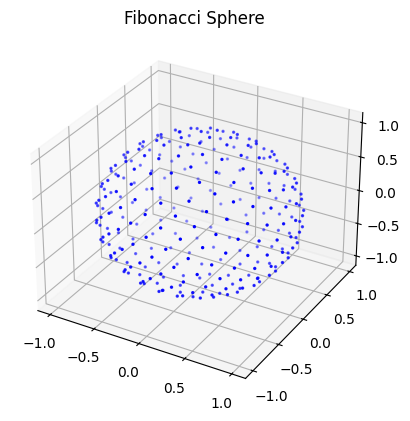

In [62]:
N = 300 # number of points
sphere_points = fibonacci_sphere(N) # Generate the Fibonacci sphere

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sphere_points[:,0], sphere_points[:,1], sphere_points[:,2], marker='o', s=2, c='blue')
plt.title('Fibonacci Sphere')
plt.show()

In [63]:
x = sphere_points  # data
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
k = 30 # number of neighbors in knn
gamma = 0.95 # information variability threshold in dimension estimation with singular values

# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma)

# Create the graph
G = vdm.make_graph(method='radius') # method must be 'radius' or 'knn', the default is 'radius'

# Orthonormal bases
O = vdm.make_orthonormal_bases()

# Print manifold dimension
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")

Estimated dimension of the manifold: 2


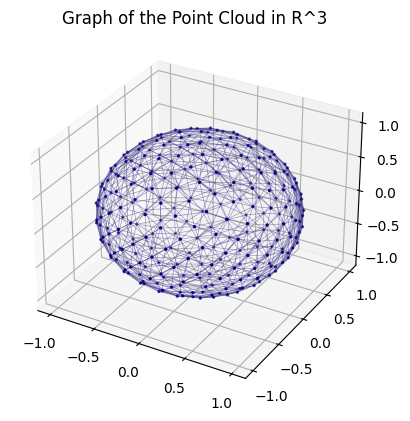

In [64]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

#### Build the Laplacian

##### Connection Laplacian

In [65]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_conn = vdm.connection_laplacian() # approximation of the connection laplacian

##### Trivial Laplacian

In [66]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
D = vdm.get_kron_degree_matrix()
D_diag= np.diag(D)
D_diag_sqrt = np.sqrt(D_diag)
L_trivial = np.kron(np.diag(d) - W, np.eye(2)) # Kronecker Graph Laplacian
L_trivial_norm = np.diag(1./D_diag_sqrt) @ L_trivial @ np.diag(D_diag_sqrt) # Normalized Kronecker Graph Laplacian

In [67]:
# Build sheaf laplacian
alignment_matrices = vdm.make_alignment_matrices()
L_sheaf = sheaf_laplacian(G,alignment_matrices,2)

#### Generate Signals

In [68]:
# Kraichnan Field Generation

# Parameters
n = 100 # number of waves
sigma = 1 # strength
U_bar = 0 # mean flow
SEED = 6111983 # random seed

def kraichnan_r3(x, k, Z, n=100, sigma=1, U_bar=0):
    '''
    Function that computes the a vector field for R^3
    x = points in R^3 (N x 3)
    k = precomputed normal random vectors (n x 3)
    Z = precomputed normal random numbers (n x 1)
    n = number of waves
    sigma = strength
    U_bar = mean flow
    seed = random seed
    '''
    # Define the field
    e1 = np.array([1, 0, 0])
    mult_factor = np.sqrt(sigma**2 / n)
    U = np.tile(U_bar*e1, (len(x),1)).astype(np.float64)
    for i in range(n):
        projector = e1 - (k[i]*k[i][0]) / np.dot(k[i], k[i])
        phase = x @ k[i] # N
        wave = Z[i] * np.cos(phase) + np.sin(phase) # N
        U -= mult_factor * wave[:,None] * projector[None,:]  # broadcast
    return U

# Monte Carlo samples
M = 100
X = np.zeros((2*N, M))

# Random seed
rng = np.random.default_rng(SEED)

for m in range(M):
    # Compute normal random vectors k_i and random scalars z_i
    k = rng.normal(size=(n,3))
    Z = rng.normal(size=n)
    U = kraichnan_r3(x,k,Z) # Field sample
    for i in range(N):
        X[2*i : 2*i+2, m] = O[i].T @ U[i] # Projection onto the orthonormal basis

#### Covariance

In [69]:
# Function that computes the empirical covariance
def empirical_covariance(X):
    X_mean = np.mean(X, axis=1, keepdims=True) # 2N x 1
    X_centered = X - X_mean # 2N x M
    cov = (X_centered @ X_centered.T) / (X.shape[1] - 1)
    return cov

# Compute the empirical covariance
cov = empirical_covariance(X)

#### Generate samples using CochainSample

In [70]:
# Create a CochainSample object
sample = CochainSample(X=X,
                       covariance=cov,
                       X_GT=X,
                       points=x,
                       local_bases=O,
                       V=x.shape[0]
                       )
# Saplming signals
sampled = sample.random_tangent_bundle_signals(Sigma=None,len_scale=10, M=500, seed=42)
# Get the results
signals = sampled.X
signal_cov = sampled.covariance
signal_GT = sampled.X_GT

#### Dictionaries

In [71]:
# Create the wavelet objects
wav_conn = Wavelet(-L_conn)
wav_trivial = Wavelet(L_trivial)
wav_trivial_norm = Wavelet(L_trivial_norm)
wav_sheaf = Wavelet(L_sheaf)

In [86]:
# Define the scales
num_scales = 5
scales = [2**(j-2) for j in range(num_scales)]
shifts = np.arange(L_trivial.shape[0])
# Build the dictionaries
dict_conn = wav_conn.make_dictionary(scales, shifts)
dict_trivial = wav_trivial.make_dictionary(scales, shifts)
dict_trivial_norm = wav_trivial_norm.make_dictionary(scales, shifts)
dict_sheaf = wav_sheaf.make_dictionary(scales, shifts)

### Sparse Signal Processing

We want to find sparse representations of the signals using the laplacian dictionaries.

To evaluate the quality of the signal representation, two measures are taken into consideration:
- Number of non-zero coefficients (or above a tolerance)
- Approximation error

In [87]:
# Find the sparse signal representations
sparse_signals_conn = []
sparse_signals_trivial = []
sparse_signals_trivial_norm = []
sparse_signals_sheaf = []

for k in  tqdm(range(50)):  # tqdm(range(signals.shape[1])):
    sparse_signals_conn.append(wav_conn.sparse_signal(signals[:,k], dict_conn))
    sparse_signals_trivial.append(wav_trivial.sparse_signal(signals[:,k], dict_trivial))
    sparse_signals_trivial_norm.append(wav_trivial_norm.sparse_signal(signals[:,k], dict_trivial_norm))
    sparse_signals_sheaf.append(wav_sheaf.sparse_signal(signals[:,k], dict_sheaf))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


In [88]:
# Compute the sparsity of the signal representations
sparsity_conn = []
sparsity_trivial = []
sparsity_trivial_norm = []
sparsity_sheaf = []

for k in range(50):
    sparsity_conn.append(np.sum(np.abs(sparse_signals_conn[k])>0) / dict_conn.shape[1] * 100)
    sparsity_trivial.append(np.sum(np.abs(sparse_signals_trivial[k])>0) / dict_trivial.shape[1] * 100)
    sparsity_trivial_norm.append(np.sum(np.abs(sparse_signals_trivial_norm[k])>0) / dict_trivial_norm.shape[1] * 100)
    sparsity_sheaf.append(np.sum(np.abs(sparse_signals_sheaf[k])>0) / dict_sheaf.shape[1] * 100)

In [89]:
# Compute the NMSE of the sparse signal represntations
nmse_conn = []
nmse_trivial = []
nmse_trivial_norm = []
nmse_sheaf = []


def NMSE(x, x_hat):
    return np.linalg.norm(x - x_hat)**2 / np.linalg.norm(x)**2

for k in range(50):
    nmse_conn.append(NMSE(signal_GT[:,k], dict_conn @sparse_signals_conn[k]))
    nmse_trivial.append(NMSE(signal_GT[:,k], dict_trivial @sparse_signals_trivial[k]))
    nmse_trivial_norm.append(NMSE(signal_GT[:,k], dict_trivial_norm @sparse_signals_trivial_norm[k]))
    nmse_sheaf.append(NMSE(signal_GT[:,k], dict_sheaf @sparse_signals_sheaf[k]))

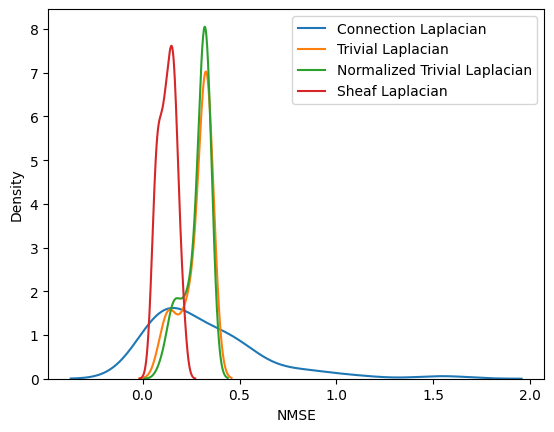

In [90]:
sns.kdeplot(nmse_conn, label='Connection Laplacian')
sns.kdeplot(nmse_trivial, label='Trivial Laplacian')
sns.kdeplot(nmse_trivial_norm, label='Normalized Trivial Laplacian')
sns.kdeplot(nmse_sheaf, label='Sheaf Laplacian')
plt.xlabel('NMSE')
plt.ylabel('Density')
plt.legend()
plt.show()

In [91]:
print(f"Mean sparsity (connection laplacian): {np.mean(sparsity_conn)}%")
print(f"Mean sparsity (trivial laplacian): {np.mean(sparsity_trivial)}%")
print(f"Mean sparsity (normalized trivial laplacian): {np.mean(sparsity_trivial_norm)}%")
print(f"Mean sparsity (sheaf laplacian): {np.mean(sparsity_sheaf)}%")

Mean sparsity (connection laplacian): 10.0%
Mean sparsity (trivial laplacian): 10.0%
Mean sparsity (normalized trivial laplacian): 10.0%
Mean sparsity (sheaf laplacian): 10.0%


In [92]:
signals.shape[0]

600

In [93]:
# Print results
print(f"Number of coefficients (connection laplacian): {np.sum(np.abs(sparse_signals_conn[0])>0)}")
print(f"Number of coefficients (trivial laplacian): {np.sum(np.abs(sparse_signals_trivial[0])>0)}")
print(f"Number of coefficients (normalized trivial laplacian): {np.sum(np.abs(sparse_signals_trivial_norm[0])>0)}")
print(f"Number of coefficients (sheaf laplacian): {np.sum(np.abs(sparse_signals_sheaf[0])>0)}")
print(f"Representation error (connection laplacian): {np.linalg.norm(dict_conn @sparse_signals_conn[0] - signal_GT[:,0])}")
print(f"Representation error (trivial laplacian): {np.linalg.norm(dict_trivial @sparse_signals_trivial[0] - signal_GT[:,0])}")
print(f"Representation error (normalized trivial laplacian): {np.linalg.norm(dict_trivial_norm @sparse_signals_trivial_norm[0] - signal_GT[:,0])}")
print(f"Representation error (sheaf laplacian): {np.linalg.norm(dict_sheaf @sparse_signals_sheaf[0] - signal_GT[:,0])}")

Number of coefficients (connection laplacian): 300
Number of coefficients (trivial laplacian): 300
Number of coefficients (normalized trivial laplacian): 300
Number of coefficients (sheaf laplacian): 300
Representation error (connection laplacian): 4.05483486143004
Representation error (trivial laplacian): 3.5385900698839308
Representation error (normalized trivial laplacian): 3.5639912191009073
Representation error (sheaf laplacian): 2.341632032317174


# Weather Dataset

### Load the Dataset

A csv file is loaded, containing Swiss weather station coordinates and heights. The stations will be the nodes in the graph built by the VDM class.

In [2]:
stations = pd.read_csv('stations_ds.csv')
display(stations)

,nat_abbr,latitude,longitude,station_height
0,ABE,47.057969,7.285350,444.00
1,ABO,46.491703,7.560703,1321.38
2,AEG,47.133636,8.608206,724.43
3,AFI,47.604669,8.670289,360.00
4,AGATT,47.265233,8.050519,475.00
...,...,...,...,...
297,WYN,47.255025,7.787475,421.99
298,ZER,46.029272,7.752433,1638.35
299,ZEV,46.578797,9.118797,1738.00
300,ZWE,46.550511,7.384917,936.00


In [3]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   nat_abbr        302 non-null    object 
 1   latitude        302 non-null    float64
 2   longitude       302 non-null    float64
 3   station_height  302 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.6+ KB


In [4]:
# Turn columns 1,2,3 (latitude, longitude, station_height) to a numpy array
station_geodetic = stations.iloc[:,1:4].to_numpy()
# Turn the coordinates from geodetic to R^3 points
x, y, z = geodetic_to_ecef(
    station_geodetic[:, 0],
    station_geodetic[:, 1],
    station_geodetic[:, 2]
)
station_points = np.column_stack((x, y, z))  # shape (N, 3)
station_points[:10]

array([[0.67575819, 0.08639101, 0.73204334],
       [0.68247416, 0.09058512, 0.72527468],
       [0.6726272 , 0.10182383, 0.7329424 ],
       [0.66653709, 0.10164081, 0.73851029],
       [0.67191781, 0.09503612, 0.73450296],
       [0.6698307 , 0.09771763, 0.73605577],
       [0.67498515, 0.09174883, 0.73210464],
       [0.68550921, 0.08325283, 0.72328838],
       [0.68029226, 0.10285349, 0.72568836],
       [0.66769497, 0.11241116, 0.73589888]])

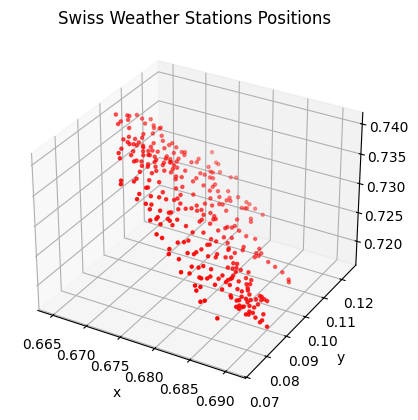

In [5]:
# Plot the cube
fig = plt.figure()  
ax = fig.add_subplot(projection='3d')
ax.scatter(station_points[:,0], station_points[:,1], station_points[:,2], marker='o', s=5, c='red')
plt.title('Swiss Weather Stations Positions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Find some distance statistics to choose good hyperparameters for the VDM class
def compute_distances(x):
    distances = []
    for i in range(x.shape[0]):
        for j in range(i+1, x.shape[0]):
            dist = np.linalg.norm(x[i] - x[j])
            distances.append(dist)
    return distances

distances = compute_distances(station_points)
print(f"Median distance between two stations: {np.median(distances)}")
print(f"Min and max distances: {np.min(distances)}, {np.max(distances)}")
print("First ten distances:")
print(sorted(distances, reverse=True)[:10])

Median distance between two stations: 0.01761227600907149
Min and max distances: 0.00037039650947565583, 0.05318045111323205
First ten distances:
[np.float64(0.05318045111323205), np.float64(0.05287267455556982), np.float64(0.052071312343405105), np.float64(0.05204996461640956), np.float64(0.05143259099883185), np.float64(0.050794923114699214), np.float64(0.05078056824714675), np.float64(0.05060660727475896), np.float64(0.050562648945038736), np.float64(0.05055124190410377)]


### Build the Graph

In [63]:
x = station_points  # point cloud
eps = 0.0003 # epsilon for the graph
eps_pca = 0.0002 # epsilon for the local PCA
k = 15 # number of neighbors in knn
gamma = 0.997 # information variability threshold in dimension estimation with singular values
vdm = VDM(x, eps, eps_pca, k, gamma)
G = vdm.make_graph()
print(f"Estimated dimension of the manifold: {vdm.estimate_dim()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1))}")

Estimated dimension of the manifold: 2
Number of edges: 22196
Graph density: 0.244175045653561


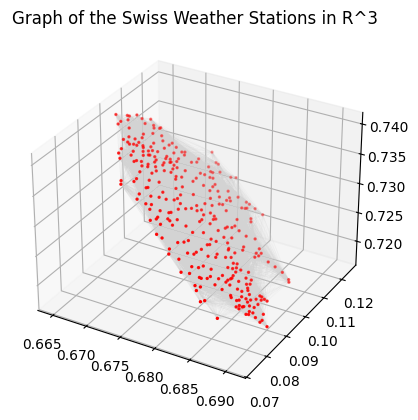

In [64]:
# Plot the graph
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='red')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='lightgrey', linewidth=0.1, alpha=0.5)
plt.title('Graph of the Swiss Weather Stations in R^3')
plt.show()

### Build the Laplacians

##### Connection Laplacian

In [8]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L_con = vdm.connection_laplacian() # approximation of the connection laplacian

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L_con)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
# Suppress imaginary part if below 1e-15
for i in range(len(eigvals)):
    if np.abs(eigvals[i].imag) < 1e-15:
        eigvals[i] = eigvals[i].real
# If all values are real now, change data type from complex to float
if np.all(np.isreal(eigvals)):
    eigvals = eigvals.astype(np.float64)
print("Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.")
print(f"Min eigenvalue: {eigvals[0]}, Max eigenvalue: {eigvals[-1]}")

Complex parts were suppressed because they were all below a 1e-15 tolerance. Data type changed to float64.
Min eigenvalue: -1.4941219944218032, Max eigenvalue: -0.25608233336434905


##### Trivial Bundle

In [ ]:
# Graph Laplacian
W = vdm.get_weight_matrix() # Weight matrix
d = vdm.get_degree_vector() # degree vector
d_sqrt = np.sqrt(d)
L_trivial = np.diag(d) - W # Graph Laplacian
L_trivial_norm = np.diag(1./d_sqrt) @ L_trivial @ np.diag(d_sqrt) # Normalized Laplacian

### Load Signals

In [108]:
# Load the signals (wind data)
wind_data_uv = np.load('wind_data_uv.npy')
wind_data_uv

array([[-0.9986295 , -0.33456534, -0.93358046, ...,  0.39999998,
         0.9801073 ,  0.52484727],
       [-0.05233597,  0.37157238,  0.35836792, ...,  0.69282037,
        -0.4993893 ,  0.60376763],
       [-0.70139384, -0.68404025, -0.70331603, ...,  1.4571847 ,
         1.0790098 , -0.03838944],
       ...,
       [-2.9870312 , -3.11127   , -3.5460484 , ..., -0.5846221 ,
        -0.48480958, -0.9563047 ],
       [ 0.76604456,  0.7269508 ,  0.7551845 , ...,  0.9439806 ,
         0.860083  ,  1.2362019 ],
       [ 0.6427875 ,  1.0777488 ,  0.9325752 , ...,  1.165719  ,
         2.2405932 ,  3.0597064 ]], shape=(302, 5616), dtype=float32)

In [119]:
u = wind_data_uv[::2,:] # zonal (east–west) wind component
v = wind_data_uv[1::2,:] # meridional (north–south) wind component
# Take the first signal
uv_signal = np.column_stack((u[:,0],v[:,0]))
uv_signal.shape

(151, 2)

In [120]:
uv_signal.shape

(151, 2)

In [123]:
O = vdm.make_orthonormal_bases()
len(O)

302

In [ ]:
# Project the signal point-wise on the tangent space of the graph
O = vdm.make_orthonormal_bases()
# ...